In [ ]:
!pip install -q datasets pyarrow pandas
!pip install -q sentence-transformers

In [ ]:
from huggingface_hub import hf_hub_download
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from datasets import load_dataset
en_hi = load_dataset("haoranxu/FLORES-200", "en-hi", split="test")
en_gu = load_dataset("haoranxu/FLORES-200", "en-gu", split="test")
en_ur = load_dataset("haoranxu/FLORES-200", "en-ur", split="test")
en_mr = load_dataset("haoranxu/FLORES-200", "en-mr", split="test")

In [ ]:
N = 200
data = {
    "en": [en_hi[i]["en-hi"]["en"] for i in range(N)],
    "hi": [en_hi[i]["en-hi"]["hi"] for i in range(N)],
    "gu": [en_gu[i]["en-gu"]["gu"] for i in range(N)],
    "ur": [en_ur[i]["en-ur"]["ur"] for i in range(N)],
    "mr": [en_mr[i]["en-mr"]["mr"] for i in range(N)],
}

for lang, sents in data.items():
    print(lang, "→", sents[0])


en → "We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.
hi → उन्होंने कहा “कि अब हमारे पास 4 महीने उम्र वाले चूहे हैं जिन्हें मधुमेह नहीं है जो मधुमेह के रोगी थे। ”
gu → "તેમણે ઉમેર્યું, ""હવે અમારી પાસે 4 મહિના પહેલા જન્મેલા ઉંદરો છે જેઓ પહેલા ડાયાબિટીસથી પીડાતા હતા પરંતુ હવે તેઓને ડાયાબિટીસ નથી."""
ur → انہوں نے مزید بتایا کہ، "اب ہمارے پاس غیر ذیابیس والے 4 مہینے کی عمر کے چوہے ہیں جنہیں شوگر ہوجایا کرتا تھا۔"
mr → ते म्हणाले, “आमच्याकडे आता 4 महिन्यांचा उंदीर आहे ज्याला मधुमेह नाही ज्याला मधुमेही होण्यासाठी वापरले जाईल.


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

In [ ]:
embeddings = {}

for lang, sentences in data.items():
    embeddings[lang] = model.encode(
        sentences,
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

results = {}

for lang in ["hi", "gu", "ur", "mr"]:
    sim = cosine_similarity(embeddings["en"], embeddings[lang])
    diag = np.diag(sim)
    results[lang] = diag


In [ ]:
for lang, sims in results.items():
    print(
        f"EN ↔ {lang.upper()} | "
        f"Mean: {sims.mean():.3f}, "
        f"Std: {sims.std():.3f}, "
        f"Min: {sims.min():.3f}"
    )


EN ↔ HI | Mean: 0.824, Std: 0.105, Min: 0.145
EN ↔ GU | Mean: 0.576, Std: 0.282, Min: -0.075
EN ↔ UR | Mean: 0.744, Std: 0.120, Min: 0.310
EN ↔ MR | Mean: 0.676, Std: 0.219, Min: -0.027


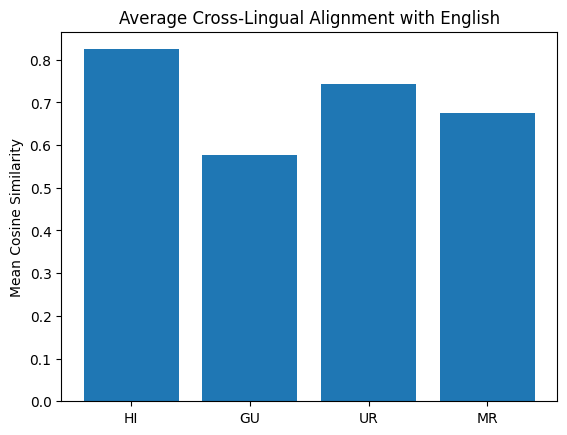

In [ ]:
means = [results[k].mean() for k in results]
labels = [k.upper() for k in results]

plt.figure()
plt.bar(labels, means)
plt.ylabel("Mean Cosine Similarity")
plt.title("Average Cross-Lingual Alignment with English")
plt.show()


In [ ]:
def extract_pairs(dataset, src="en", tgt=None, N=200):
    en_sents = []
    tgt_sents = []
    for i in range(N):
        pair = dataset[i]["en-" + tgt]
        en_sents.append(pair["en"])
        tgt_sents.append(pair[tgt])
    return en_sents, tgt_sents

en_hi_s, hi_s = extract_pairs(en_hi, tgt="hi", N=N)
en_gu_s, gu_s = extract_pairs(en_gu, tgt="gu", N=N)
en_ur_s, ur_s = extract_pairs(en_ur, tgt="ur", N=N)
en_mr_s, mr_s = extract_pairs(en_mr, tgt="mr", N=N)

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

models = {
    "MiniLM": SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"),
    "LaBSE": SentenceTransformer("sentence-transformers/LaBSE")
}

def mean_cosine(model, en_sents, tgt_sents):
    emb_en = model.encode(en_sents, normalize_embeddings=True)
    emb_tgt = model.encode(tgt_sents, normalize_embeddings=True)
    sims = np.diag(cosine_similarity(emb_en, emb_tgt))
    return sims.mean()

results = {
    "HI": {},
    "GU": {},
    "UR": {},
    "MR": {}
}

for name, model in models.items():
    results["HI"][name] = mean_cosine(model, en_hi_s, hi_s)
    results["GU"][name] = mean_cosine(model, en_gu_s, gu_s)
    results["UR"][name] = mean_cosine(model, en_ur_s, ur_s)
    results["MR"][name] = mean_cosine(model, en_mr_s, mr_s)


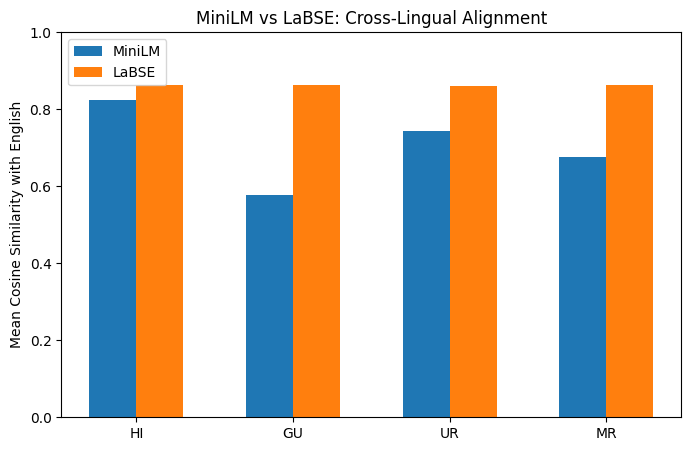

In [ ]:
languages = list(results.keys())
minilm_scores = [results[l]["MiniLM"] for l in languages]
labse_scores = [results[l]["LaBSE"] for l in languages]

x = np.arange(len(languages))
width = 0.3

plt.figure(figsize=(8,5))
plt.bar(x - width/2, minilm_scores, width, label="MiniLM")
plt.bar(x + width/2, labse_scores, width, label="LaBSE")

plt.xticks(x, languages)
plt.ylabel("Mean Cosine Similarity with English")
plt.title("MiniLM vs LaBSE: Cross-Lingual Alignment")
plt.legend()
plt.ylim(0, 1)
plt.show()